Build full model based on finetuned baseline and over sampling technique

In [2]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import joblib

In [3]:
df = pd.read_csv('clean_training_set.csv', index_col='id')

In [4]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [5]:
df.shape

(59400, 21)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59400 entries, 69572 to 26348
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   amount_tsh         59400 non-null  float64
 1   gps_height         59400 non-null  float64
 2   longitude          59400 non-null  float64
 3   latitude           59400 non-null  float64
 4   basin              59400 non-null  object 
 5   region             59400 non-null  object 
 6   district_code      59400 non-null  int64  
 7   ward               59400 non-null  object 
 8   population         59400 non-null  float64
 9   scheme_management  59400 non-null  object 
 10  extraction_type    59400 non-null  object 
 11  management         59400 non-null  object 
 12  payment_type       59400 non-null  object 
 13  water_quality      59400 non-null  object 
 14  quantity           59400 non-null  object 
 15  source             59400 non-null  object 
 16  waterpoint_type    5940

In [7]:
df.status_group.unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

In [8]:
df['status_group'] = df['status_group'].map({'functional': 2,'functional needs repair': 1,'non functional': 0})

In [9]:
features = df.columns.drop(['status_group'])

In [10]:
features = features.to_list()

In [11]:
X = df[features]

In [12]:
y = df['status_group']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tertiary Classifier

Random Forest

In [14]:
categorical = X.select_dtypes('object').columns
num_col = X.select_dtypes(['int','float']).columns

In [15]:
ohe = OneHotEncoder(handle_unknown='ignore')
rs = RobustScaler()

In [16]:
num_transformer = make_pipeline(rs)
cat_transformer = make_pipeline(ohe)

In [17]:
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_col),
                    ('cat', cat_transformer, categorical)])

In [18]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [19]:
joblib.dump(preprocessor, 'prepoc.pkl')

['prepoc.pkl']

In [20]:
rf = RandomForestClassifier(min_samples_split= 5,n_estimators = 100,class_weight='balanced')

In [21]:
rf.fit(X_train_transformed, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_split=5)

In [22]:
preds_train = rf.predict(X_train_transformed)
preds_test = rf.predict(X_test_transformed)

In [23]:
balanced_accuracy_score(y_train, preds_train)

0.9622913874855712

In [24]:
balanced_accuracy_score(y_test, preds_test)

0.7019702534241556

# SMOTE oversampling

In [55]:
X_transformed = preprocessor.fit_transform(X)

In [56]:
X_transformed.shape, y.shape

((59400, 2240), (59400,))

In [57]:
joblib.dump(preprocessor, 'prepoc.pkl')

['prepoc.pkl']

In [27]:
smote = SMOTE(sampling_strategy = 'auto', n_jobs = -1)

In [28]:
X_sampled, y_sampled = smote.fit_resample(X_transformed, y)

/Users/Flotchi/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)

# SMOTE + RF

In [30]:
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_split=5)

In [31]:
y_pred = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

In [32]:
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
print(f"TEST: {balanced_accuracy_score(y_test, y_pred_test)}")

TRAIN: 0.9728076808939159
TEST: 0.8753545353410245


In [33]:
cm = confusion_matrix(y_test, y_pred_test)

<Figure size 1600x800 with 0 Axes>

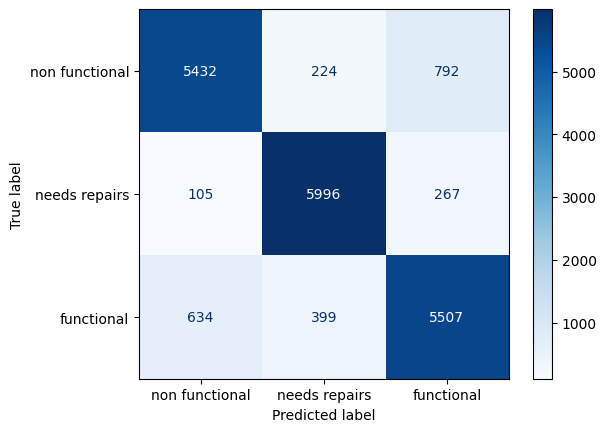

In [51]:
plt.figure(figsize=(16,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non functional','needs repairs','functional'])
disp.plot(cmap=plt.cm.Blues) 
plt.show()

In [52]:
joblib.dump(rf, 'rf.pkl')

['rf.pkl']

# Submission

In [ ]:
X_sub = pd.read_csv('Test Values.csv')

In [ ]:
X_sub.shape

In [ ]:
y_sub = rf.predict()